# <span style="color:#F72585"><center>Inicio Rápido</center></span>

## <span style="color:#4361EE">Introducción</span>

En esta lección construimos nuestra primera red neuronal con PyTorch. Usamos el famoso ejemplo [fashion mnist](https://www.kaggle.com/zalando-research/fashionmnist). En este caso tomaremos los datos directamente de la librería `torchvision`.

### <span style="color:#4CC9F0">Instalar Pytorch</span>


En consola ejecute el siguiente comando. 

In [3]:
#conda install -c pytorch pytorch

## <span style="color:#4361EE">Trabajando con datos</span>

PyTorch tiene dos primitivas para trabajar con datos: `torch.utils.data.DataLoader` y `torch.utils.data.Dataset`. *Dataset* almacena las muestras y sus etiquetas correspondientes, y *DataLoader* envuelve un iterable alrededor de *Dataset*.

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

import matplotlib.pyplot as plt
import numpy as np

from torch.nn import Flatten, Sequential, Linear, ReLU

PyTorch ofrece bibliotecas específicas de dominio como `TorchText`, `TorchVision` y `TorchAudio`, todas las cuales incluyen conjuntos de datos. Para este tutorial, usaremos un conjunto de datos de `TorchVision`.

El módulo `torchvision.datasets` contiene objetos de conjunto de datos para muchos datos de visión del mundo real como CIFAR, COCO ([lista completa aquí](https://pytorch.org/vision/stable/datasets.html)). En este tutorial, usamos el conjunto de datos FashionMNIST. Cada conjunto de datos de TorchVision incluye dos argumentos: *transform* y *target_transform* para modificar las muestras y las etiquetas respectivamente.

En el siguiente fragmento de código se leen los datos para entrenamiento y test. Si aún no se han bajado los datos, Pytorch lo hace por esta única ocasión. La próxima vez los leerá de la carpeta interna 'data'. El parámetro *transform* permite convertir los datos a un formato específico. En este caso a tensores de Torch.

In [5]:
# Baja los datos de entrenamiento de open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Baja los datos test data de open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Pasamos el *Dataset* como un parámetro para `DataLoader`
Esto envuelve un iterable sobre nuestro conjunto de datos y admite procesamiento por lotes, muestreo, barajado y carga de datos multiproceso automáticos. Aquí definimos un tamaño de lote de 64, es decir, cada elemento en el cargador de datos iterable devolverá un lote de 64 imágenes con sus etiquetas.

### <span style="color:#4CC9F0">Una primera imagen de los datos</span>


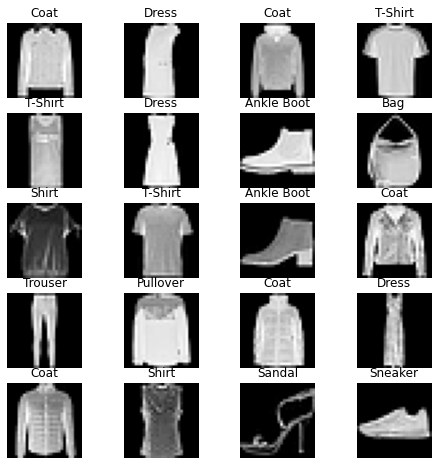

In [6]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(training_data));
    img = training_data[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[training_data[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [8]:
batch_size = 64

#crea data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(len(train_dataloader.datasets))

for X, y in test_dataloader:
    print('X[N, C, H, W]: ', X.shape)
    print('Shape of y: ', y.shape, y.dtype)
    break

AttributeError: 'DataLoader' object has no attribute 'datasets'

## <span style="color:#4361EE">Creando modelos</span>

Para definir una red neuronal en PyTorch, creamos una clase que hereda de nn.Module. Definimos las capas de la red en la función __init__ y especificamos cómo pasarán los datos a través de la red en la función de reenvío. Para acelerar las operaciones en la red neuronal, lo trasladamos a la GPU si está disponible.

In [ ]:
# Obtiene gpu o cpu device para el entrenamiento
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using {} device'.format(device))

# define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = Flatten()
        self.linear_relu_stack = Sequential(
            Linear(28*28, 512),
            ReLU(),
            Linear(512, 512),
            ReLU(),
            Linear(512, 10),
            ReLU()
        )
        
    # la función forward es la que define la estructura de la red
    # en este ejemplo aceptamos solo una entrada, pero si lo desea,
    # siéntete libre de usar más
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


```{admonition} Nota
:class: note
Cuando se invoca model, automáticamente se ejecuta la función *\_\_call\_\_* de la clase. En Pytorch la clase `nn.Module` de la cual derivamos  nuestra clase llama internamente a la función *forward*, que nosotros debemos sobrecargar (escribir para definir nuestro modelo), como puede verificar [aquí](https://github.com/pytorch/pytorch/blob/472be69a736c0b2aece4883be9f8b18e2f3dfbbd/torch/nn/modules/module.py#L487).
```


## <span style="color:#4361EE">Función de pérdida y optimizador</span>

### <span style="color:#4CC9F0">Función de pérdida y optimizador</span>


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### <span style="color:#4CC9F0">Función de entrenamiento</span>

In [ ]:
def train(dataloader, model, loss_fn, optimizer): 
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Calcula error de predicción
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad() # coloca el gradiente en cero
        loss.backward() # Calcula el gradiente a lo largo de la red de forma aditiva
        optimizer.step() # ejecuta el paso del SDG
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss: {loss:>7f} [{current:5d}/{size:>5d}]')
            

### <span style="color:#4CC9F0">Función de prueba (testeo) del modelo</span>


In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # le indica la modelo que trabajará en modo inferencia (no entrenamiento)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    

## <span style="color:#4361EE">Entrenamiento y validación</span>

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------


NameError: name 'loss_fn' is not defined

## <span style="color:#4361EE">Guardando y recuperando el modelo</span>


### <span style="color:#4CC9F0">Guardar el modelo</span>


In [ ]:
path = '../Checkpoints/Model_0'
torch.save(model.state_dict(), path)
print(' Modelo Pytorch guardado: ', path)

FileNotFoundError: [Errno 2] No such file or directory: '../Checkpoints/Model_0'

### <span style="color:#4CC9F0">Carga el modelo</span>


In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load(path))

NameError: name 'path' is not defined

## <span style="color:#4361EE">Predicción</span>

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x,y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    

Predicted: "Ankle boot", Actual: "Ankle boot"


## <span style="color:#4361EE">Referencias</span> 


1. Basado en los [tutoriales de Pytorch](https://pytorch.org/tutorials/)
1. [Deep learning for coders with FastAI and Pytorch](http://library.lol/main/F13E85845AE48D9FD7488FE7630A9FD3)